## Przewidywanie liganda pasującego do kieszeni wiążącej (one-hot):

In [1]:
import Voronoi3D
from Bio.PDB import PDBParser
import numpy as np
import glob
from keras.layers import Dense, Input
from keras.models import Sequential, load_model
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt

In [2]:
AMINOACIDS = "ALA CYS ASP GLU PHE GLY HIS ILE LYS LEU MET ASN PRO GLN ARG SER THR VAL TRP TYR".split()

In [3]:
# Funkcja wczytująca strukturę, rozpinająca nad nią diagram Woronoja, znajdująca miejsca wiązania
# ligandów i budująca reprezentację one-hot znalezionych miejsc wiązania.
def one_hot_encode(structure_path, ligand_name):
    # Wczytanie struktury
    parser = PDBParser()
    structure = parser.get_structure("STRUCTURE", structure_path)

    coords = [atom.get_coord() for atom in structure.get_atoms()]

    min_x = min(coords, key=lambda coord: coord[0])[0]
    max_x = max(coords, key=lambda coord: coord[0])[0]

    min_y = min(coords, key=lambda coord: coord[1])[1]
    max_y = max(coords, key=lambda coord: coord[1])[1]

    min_z = min(coords, key=lambda coord: coord[2])[2]
    max_z = max(coords, key=lambda coord: coord[2])[2]

    container = Voronoi3D.RectangularContainer(min_x, max_x, min_y, max_y, min_z, max_z)

    for residue in structure.get_residues():
        for atom in residue.get_atoms():
            if atom.get_name()[0] != "H" and residue.get_resname() != "HOH":
                container.add(atom.get_serial_number(), *atom.get_coord(), residue=residue.get_resname(), atom=atom.get_name(), seg_id=residue.get_full_id()[3][1])
            
    diagram = Voronoi3D.Diagram(container)
    
    #---------------------------------------------------------------------------------
    
    # Wybranie komórek zawierających ligand
    
    ligands_cells = []
    prev_res = -1

    for cell in diagram:
        if cell.generator.residue == ligand_name:
            if cell.generator.seg_id == prev_res:
                ligands_cells[-1].append(cell)
            else:
                ligands_cells.append([cell])
                prev_res = cell.generator.seg_id
                
    #---------------------------------------------------------------------------------
    
    # Budowanie kodowania one-hot
    encoding_vectors = []
    
    for ligand in ligands_cells:
        cells_ids = set([cell.generator.id for cell in ligand])
        residues = set([])
        
        for cell in ligand:
            for face in cell:
                if face.neighbor not in cells_ids:
                    residues.add(diagram.cell(face.neighbor).generator.residue)
                    
        encoding = []
        
        for residue in AMINOACIDS:
            if residue in residues:
                encoding.append(1)
            else:
                encoding.append(0)
                
        encoding_vectors.append(np.array(encoding))
        
    return encoding_vectors

In [4]:
# Wczytanie miejsc wiążących dla 6 ligandów (po 100)

dataset = []

# Wczytanie CLR
pdb_files = glob.glob(f"..\\data\\CLR\\*")

for path in pdb_files:
    if len(dataset) > 100:
        break

    encodings = one_hot_encode(path, "CLR")

    for vec in encodings:
        dataset.append((vec, np.array([1, 0, 0, 0, 0, 0])))


# Wczytanie ATP
pdb_files = glob.glob(f"..\\data\\ATP\\*")

for path in pdb_files:
    if len(dataset) > 200:
        break

    encodings = one_hot_encode(path, "ATP")

    for vec in encodings:
        dataset.append((vec, np.array([0, 1, 0, 0, 0, 0])))


# Wczytanie NDP
pdb_files = glob.glob(f"..\\data\\NDP\\*")

for path in pdb_files:
    if len(dataset) > 300:
        break

    encodings = one_hot_encode(path, "NDP")

    for vec in encodings:
        dataset.append((vec, np.array([0, 0, 1, 0, 0, 0])))


# Wczytanie UPG
pdb_files = glob.glob(f"..\\data\\UPG\\*")

for path in pdb_files:
    if len(dataset) > 400:
        break

    encodings = one_hot_encode(path, "UPG")

    for vec in encodings:
        dataset.append((vec, np.array([0, 0, 0, 1, 0, 0])))


# Wczytanie GLC
pdb_files = glob.glob(f"..\\data\\GLC\\*")

for path in pdb_files:
    if len(dataset) > 500:
        break

    encodings = one_hot_encode(path, "GLC")

    for vec in encodings:
        dataset.append((vec, np.array([0, 0, 0, 0, 1, 0])))


# Wczytanie BGC
pdb_files = glob.glob(f"..\\data\\BGC\\*")

for path in pdb_files:
    if len(dataset) > 600:
        break

    encodings = one_hot_encode(path, "BGC")

    for vec in encodings:
        dataset.append((vec, np.array([0, 0, 0, 0, 0, 1])))

c:\Studia_2022\Nauczanie_maszynowe\Projekt\env\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4717.
  warnings.warn(
c:\Studia_2022\Nauczanie_maszynowe\Projekt\env\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4746.
  warnings.warn(
c:\Studia_2022\Nauczanie_maszynowe\Projekt\env\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4775.
  warnings.warn(
c:\Studia_2022\Nauczanie_maszynowe\Projekt\env\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4826.
  warnings.warn(
c:\Studia_2022\Nauczanie_maszynowe\Projekt\env\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4870.
  warnings.warn(
c:\Studia_2022\Nauczanie_maszynowe\Projekt\env\lib\site-packages\Bio\P

In [5]:
# Tworzenie zbiorów uczącego i testowego (80:20).

random.shuffle(dataset)

samples = [x[0] for x in dataset]
labels = [x[1] for x in dataset]

samples_train, samples_test, labels_train, labels_test = train_test_split(
    samples, labels, test_size=0.2)

samples_train = np.array(samples_train)
samples_test = np.array(samples_test)

labels_train = np.array(labels_train)
labels_test = np.array(labels_test)


### Przegląd architektur sieci neuronowych:

In [6]:
model = Sequential([
    Dense(20, activation='relu'),
    Dense(256, kernel_initializer="normal", activation='relu'),
    Dense(6, kernel_initializer="normal", activation='sigmoid'),
])

model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [7]:
hist = model.fit(samples_train, labels_train,
                 batch_size=8, epochs=70,
                 validation_data=(samples_test, labels_test))

Epoch 1/70
60/60 [==============================] - 1s 4ms/step - loss: 1.7437 - accuracy: 0.3250 - val_loss: 1.6847 - val_accuracy: 0.3554
Epoch 2/70
60/60 [==============================] - 0s 1ms/step - loss: 1.5338 - accuracy: 0.4500 - val_loss: 1.3777 - val_accuracy: 0.4793
Epoch 3/70
60/60 [==============================] - 0s 1ms/step - loss: 1.2269 - accuracy: 0.5417 - val_loss: 1.0700 - val_accuracy: 0.6116
Epoch 4/70
60/60 [==============================] - 0s 1ms/step - loss: 1.0258 - accuracy: 0.5646 - val_loss: 0.9111 - val_accuracy: 0.6777
Epoch 5/70
60/60 [==============================] - 0s 1ms/step - loss: 0.9171 - accuracy: 0.6250 - val_loss: 0.8251 - val_accuracy: 0.7025
Epoch 6/70
60/60 [==============================] - 0s 2ms/step - loss: 0.8572 - accuracy: 0.6562 - val_loss: 0.7591 - val_accuracy: 0.7603
Epoch 7/70
60/60 [==============================] - 0s 2ms/step - loss: 0.8225 - accuracy: 0.6771 - val_loss: 0.7505 - val_accuracy: 0.7025
Epoch 8/70
60/60 [==

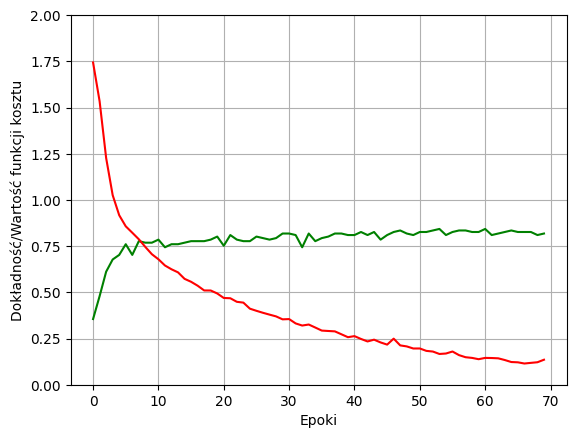

In [8]:
plt.plot(hist.epoch, hist.history["val_accuracy"], color="green")
plt.plot(hist.epoch, hist.history["loss"], color="red")
plt.ylim(0, 2)
plt.xlabel("Epoki")
plt.ylabel("Dokładność/Wartość funkcji kosztu")
plt.grid()
plt.show()

In [9]:
pred = model.predict(samples_test)

count = 0

for pred_vec, label_vec in zip(pred, labels_test):
    if np.argmax(pred_vec) == np.argmax(label_vec):
        count += 1

print(f"Dokładność: {round(count * 100 / len(labels_test), 3)}%")

4/4 [==============================] - 0s 1ms/step
Dokładność: 81.818%


In [10]:
model = Sequential([
    Dense(20, activation='relu'),
    Dense(256, kernel_initializer="normal", activation='relu'),
    Dense(64, kernel_initializer="normal", activation='relu'),
    Dense(6, kernel_initializer="normal", activation='sigmoid'),
])

model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])


In [11]:
hist = model.fit(samples_train, labels_train,
                 batch_size=8, epochs=70,
                 validation_data=(samples_test, labels_test))


Epoch 1/70
60/60 [==============================] - 1s 3ms/step - loss: 1.7047 - accuracy: 0.3063 - val_loss: 1.4351 - val_accuracy: 0.3802
Epoch 2/70
60/60 [==============================] - 0s 1ms/step - loss: 1.3504 - accuracy: 0.4417 - val_loss: 1.0951 - val_accuracy: 0.5207
Epoch 3/70
60/60 [==============================] - 0s 1ms/step - loss: 1.1326 - accuracy: 0.5604 - val_loss: 0.9671 - val_accuracy: 0.5620
Epoch 4/70
60/60 [==============================] - 0s 1ms/step - loss: 1.0097 - accuracy: 0.6042 - val_loss: 0.8760 - val_accuracy: 0.6198
Epoch 5/70
60/60 [==============================] - 0s 1ms/step - loss: 0.9322 - accuracy: 0.5938 - val_loss: 0.7722 - val_accuracy: 0.7107
Epoch 6/70
60/60 [==============================] - 0s 1ms/step - loss: 0.8402 - accuracy: 0.6354 - val_loss: 0.7964 - val_accuracy: 0.6529
Epoch 7/70
60/60 [==============================] - 0s 2ms/step - loss: 0.8043 - accuracy: 0.6583 - val_loss: 0.7346 - val_accuracy: 0.6529
Epoch 8/70
60/60 [==

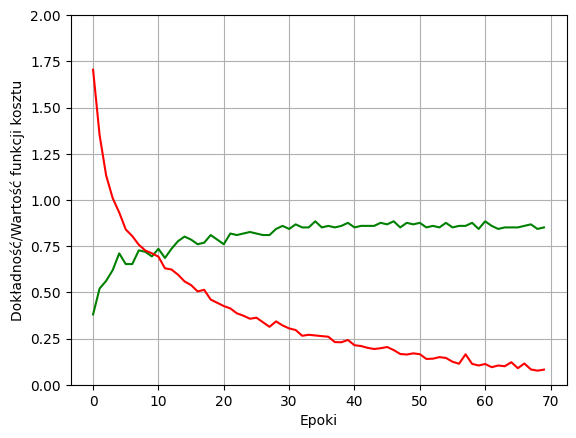

In [12]:
plt.plot(hist.epoch, hist.history["val_accuracy"], color="green")
plt.plot(hist.epoch, hist.history["loss"], color="red")
plt.ylim(0, 2)
plt.xlabel("Epoki")
plt.ylabel("Dokładność/Wartość funkcji kosztu")
plt.grid()
plt.show()


In [13]:
pred = model.predict(samples_test)

count = 0

for pred_vec, label_vec in zip(pred, labels_test):
    if np.argmax(pred_vec) == np.argmax(label_vec):
        count += 1

print(f"Dokładność: {round(count * 100 / len(labels_test), 3)}%")


4/4 [==============================] - 0s 1ms/step
Dokładność: 85.124%


In [14]:
model = Sequential([
    Dense(20, activation='relu'),
    Dense(256, kernel_initializer="normal", activation='relu'),
    Dense(128, kernel_initializer="normal", activation='relu'),
    Dense(64, kernel_initializer="normal", activation='relu'),
    Dense(6, kernel_initializer="normal", activation='sigmoid'),
])

model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])


In [15]:
hist = model.fit(samples_train, labels_train,
                 batch_size=8, epochs=70,
                 validation_data=(samples_test, labels_test))

Epoch 1/70
60/60 [==============================] - 1s 7ms/step - loss: 1.7529 - accuracy: 0.3333 - val_loss: 1.5616 - val_accuracy: 0.4050
Epoch 2/70
60/60 [==============================] - 0s 1ms/step - loss: 1.3337 - accuracy: 0.4625 - val_loss: 1.1576 - val_accuracy: 0.4711
Epoch 3/70
60/60 [==============================] - 0s 2ms/step - loss: 1.0943 - accuracy: 0.5229 - val_loss: 0.9549 - val_accuracy: 0.5372
Epoch 4/70
60/60 [==============================] - 0s 2ms/step - loss: 1.0016 - accuracy: 0.5604 - val_loss: 0.9926 - val_accuracy: 0.6033
Epoch 5/70
60/60 [==============================] - 0s 2ms/step - loss: 0.9203 - accuracy: 0.5833 - val_loss: 0.8805 - val_accuracy: 0.6033
Epoch 6/70
60/60 [==============================] - 0s 1ms/step - loss: 0.8767 - accuracy: 0.6021 - val_loss: 0.8933 - val_accuracy: 0.5868
Epoch 7/70
60/60 [==============================] - 0s 1ms/step - loss: 0.8239 - accuracy: 0.6187 - val_loss: 0.9757 - val_accuracy: 0.6116
Epoch 8/70
60/60 [==

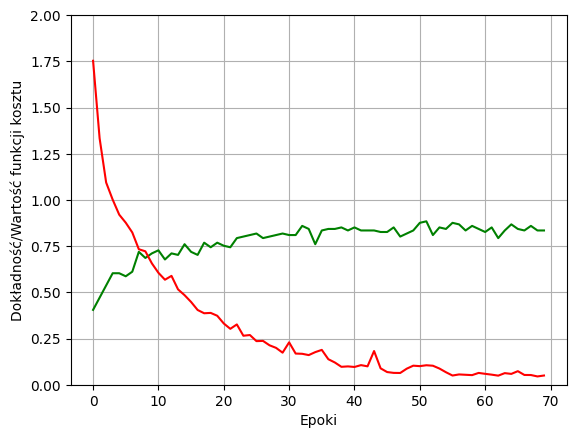

In [16]:
plt.plot(hist.epoch, hist.history["val_accuracy"], color="green")
plt.plot(hist.epoch, hist.history["loss"], color="red")
plt.ylim(0, 2)
plt.xlabel("Epoki")
plt.ylabel("Dokładność/Wartość funkcji kosztu")
plt.grid()
plt.show()

In [17]:
pred = model.predict(samples_test)

count = 0

for pred_vec, label_vec in zip(pred, labels_test):
    if np.argmax(pred_vec) == np.argmax(label_vec):
        count += 1

print(f"Dokładność: {round(count * 100 / len(labels_test), 3)}%")

4/4 [==============================] - 0s 2ms/step
Dokładność: 83.471%


In [18]:
model = Sequential([
    Dense(20, activation='relu'),
    Dense(1024, kernel_initializer="normal", activation='relu'),
    Dense(256, kernel_initializer="normal", activation='relu'),
    Dense(64, kernel_initializer="normal", activation='relu'),
    Dense(6, kernel_initializer="normal", activation='sigmoid'),
])

model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [19]:
hist = model.fit(samples_train, labels_train,
                 batch_size=8, epochs=100,
                 validation_data=(samples_test, labels_test))

Epoch 1/100
60/60 [==============================] - 1s 7ms/step - loss: 1.6047 - accuracy: 0.3354 - val_loss: 1.2402 - val_accuracy: 0.5041
Epoch 2/100
60/60 [==============================] - 0s 4ms/step - loss: 1.1468 - accuracy: 0.5667 - val_loss: 1.0449 - val_accuracy: 0.5620
Epoch 3/100
60/60 [==============================] - 0s 5ms/step - loss: 0.9532 - accuracy: 0.5833 - val_loss: 0.8532 - val_accuracy: 0.6942
Epoch 4/100
60/60 [==============================] - 0s 5ms/step - loss: 0.8610 - accuracy: 0.6417 - val_loss: 0.7947 - val_accuracy: 0.6529
Epoch 5/100
60/60 [==============================] - 0s 4ms/step - loss: 0.7824 - accuracy: 0.6917 - val_loss: 0.8836 - val_accuracy: 0.6198
Epoch 6/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6753 - accuracy: 0.7229 - val_loss: 0.7034 - val_accuracy: 0.7438
Epoch 7/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6020 - accuracy: 0.7750 - val_loss: 0.5953 - val_accuracy: 0.7769
Epoch 8/100
6

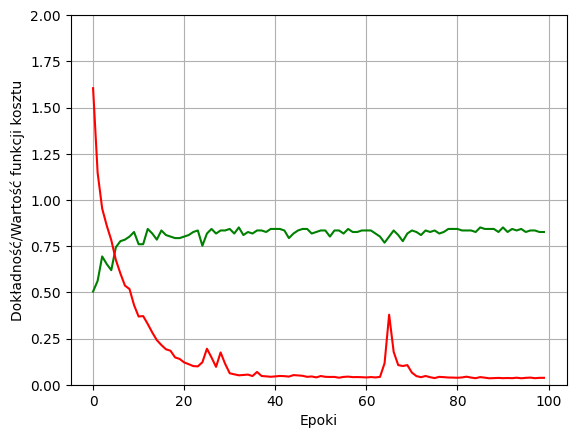

In [20]:
plt.plot(hist.epoch, hist.history["val_accuracy"], color="green")
plt.plot(hist.epoch, hist.history["loss"], color="red")
plt.ylim(0, 2)
plt.xlabel("Epoki")
plt.ylabel("Dokładność/Wartość funkcji kosztu")
plt.grid()
plt.show()

In [21]:
pred = model.predict(samples_test)

count = 0

for pred_vec, label_vec in zip(pred, labels_test):
    if np.argmax(pred_vec) == np.argmax(label_vec):
        count += 1

print(f"Dokładność: {round(count * 100 / len(labels_test), 3)}%")

4/4 [==============================] - 0s 2ms/step
Dokładność: 82.645%


### Wnioski:
- Repreezentacja one-hot miejsc wiązania w tym przypadku zdała egzamin - rozróżnienie było dobre (wcale nie musi tak być, bardzo podobne pod względem składu miejsca wiązania będą słabo rozróżnialne w tym kodowaniu),
- Już najprostsza architektura sieci miała wystarczającą pojemność aby dawać predykcje z dokładnościa na poziomie ~80% - zwiększanie rozmiaru sieci nie poprawiało znacząco dokładności.